# GDS Taper
> Create a Taper and Simulate

In [1]:
import meow as mw
import gdsfactory as gf  # pip install meow-sim[gds]
from gdsfactory.cross_section import cross_section
import matplotlib.pyplot as plt
import numpy as np

## Example Taper

> Note: `meow` expects the propagation direction to be the `z`-axis! This makes the `zx`-plane parallel with the chip and the `y`-axis perpendicular to the chip. Somewhat confusingly, the (x, y) GDS coordinate tuple hence maps onto the (z, x) `meow` coordinate tuple. Whereas the y coordinate from meow denotes the direction perpendicular to the chip. (I will probably change the `meow` convention in the future.)

In [2]:
def example_gds_cross_section(
    width: float = 0.450,
    clad_width: float = 2.0,
) -> gf.CrossSection:
    """a strip waveguide cross section

    Args:
        width:  the width of the strip waveguide
        clad_width: the width of the cladding
    """
    core_width = width
    port_names = ("in0", "out0")
    sections = (
        gf.Section(width=core_width, offset=0, layer=(1, 0), name="core"),
        gf.Section(
            width=clad_width,
            offset=0.5 * (core_width + clad_width),
            layer=(2, 0),
            name="upper",
        ),
        gf.Section(
            width=clad_width,
            offset=-0.5 * (core_width + clad_width),
            layer=(2, 0),
            name="lower",
        ),
    )
    cs = cross_section(
        width=width,
        port_names=port_names,
        sections=sections,
    )
    return cs

In [3]:
@gf.cell
def example_taper(
    width_input: float = 0.450,
    width_output: float = 1.0,
    length: float = 10.0,
) -> gf.Component:
    """create a linear taper

    Args:
        width_input: input width of the linear taper
        width_output: output width of the linear taper
        length: the length of the linear taper
    """
    input_cs = example_gds_cross_section(width_input)
    output_cs = example_gds_cross_section(width_output)
    transition = gf.path.transition(input_cs, output_cs, width_type="linear")
    length = gf.snap.snap_to_grid(length)  # type: ignore
    path = gf.path.straight(length)
    component = gf.path.extrude_transition(p=path, transition=transition)
    return component

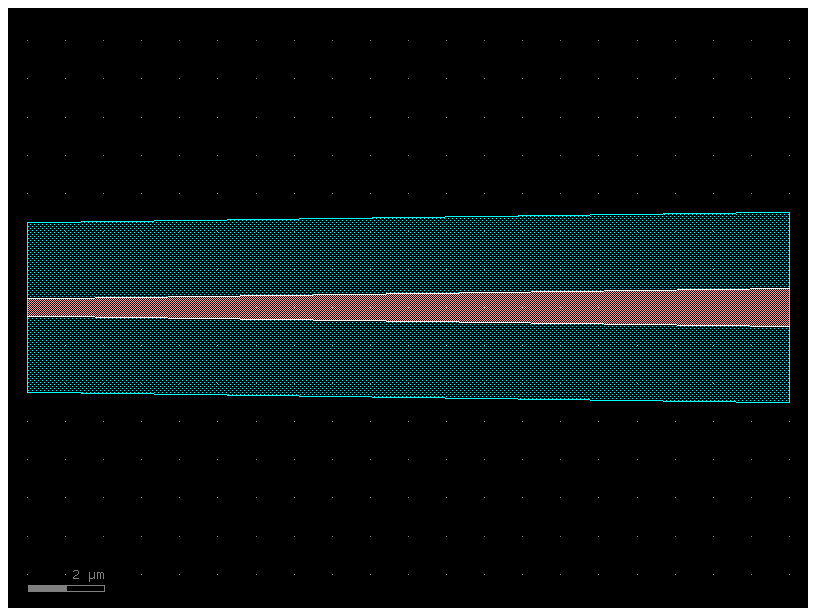

In [4]:
taper = example_taper(width_input=0.45, width_output=1.0, length=20)
taper

## Example Structure Map

In [5]:
def example_extrusions(
    t_slab: float = 0.020,
    t_soi: float = 0.220,
    t_ox: float = 1.0,
):
    """create some simple extrusion rules

    Args:
        t_slab: the slab thickness
        t_soi: the SOI thickness
        t_ox: the oxide layer thickness
    """
    extrusions = {
        (1, 0): [
            mw.GdsExtrusionRule(
                material=mw.silicon,
                h_min=0.0,
                h_max=0.0 + t_soi,
                mesh_order=1,
            ),
            mw.GdsExtrusionRule(
                material=mw.silicon_oxide,
                h_min=-1.0,
                h_max=t_soi + t_ox,
                buffer=t_ox / 2,
                mesh_order=2,
            ),
        ],
        (2, 0): [
            mw.GdsExtrusionRule(
                material=mw.silicon,
                h_min=0.0,
                h_max=0.0 + t_slab,
                mesh_order=1,
            ),
            mw.GdsExtrusionRule(
                material=mw.silicon_oxide,
                h_min=-1.0,
                h_max=t_slab + t_ox,
                mesh_order=2,
            ),
        ],
    }
    return extrusions

## Extrude GDS

In [6]:
extrusion_rules = example_extrusions()
structs = mw.extrude_gds(taper, extrusion_rules)
mw.visualize(structs, scale=(1, 1, 0.2))

## Divide into Cells

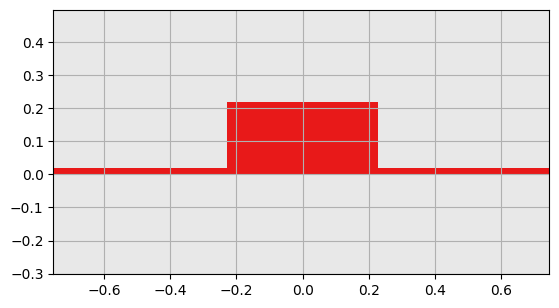

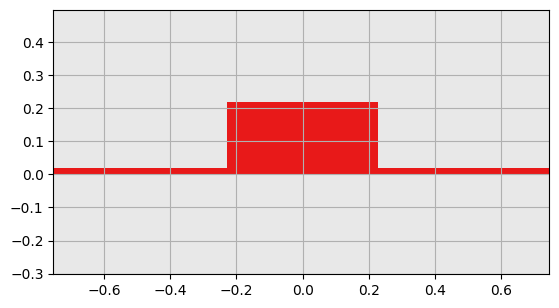

In [7]:
w_sim = 1.0
h_sim = 1.0
mesh = 100
num_cells = 10
dbu = taper.layout().dbu
taper_length = abs(taper.bbox().right - taper.bbox().left) * dbu
Ls = [taper_length / num_cells for _ in range(num_cells)]

cells = mw.create_cells(
    structures=structs,
    mesh=mw.Mesh2D(
        x=np.linspace(-0.75, 0.75, mesh + 1),
        y=np.linspace(-0.3, 0.5, mesh + 1),
    ),
    Ls=Ls,
)

mw.visualize(cells[0], cbar=False)
plt.show()

mw.visualize(cells[-1], cbar=False)
plt.show()

## Find Cross Sections

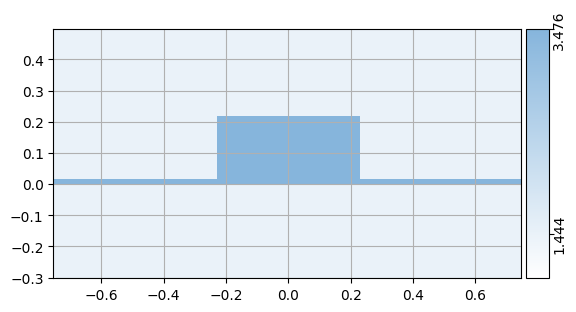

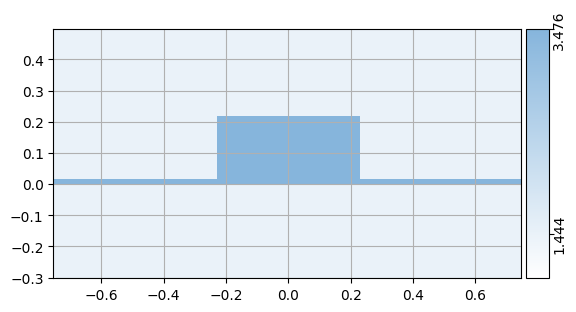

In [8]:
env = mw.Environment(wl=1.55, T=25.0)
css = [mw.CrossSection.from_cell(cell=cell, env=env) for cell in cells]

mw.visualize(css[0])
mw.visualize(css[-1])

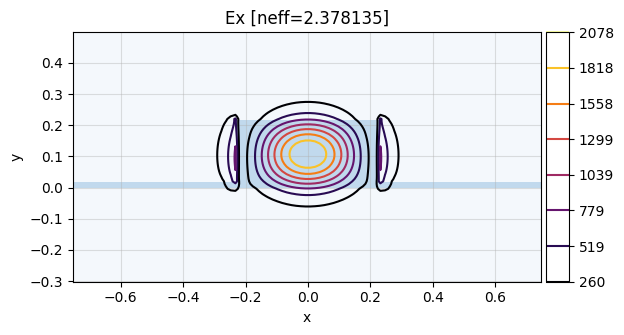

In [9]:
num_modes = 4
modes = mw.compute_modes(css[0], num_modes=num_modes)
mw.visualize(modes[0])

## Compute Modes (FDE)

In [10]:
%%time
num_modes = 4
modes = [mw.compute_modes(cs, num_modes=num_modes) for cs in css]

CPU times: user 15.4 s, sys: 137 ms, total: 15.5 s
Wall time: 12.6 s


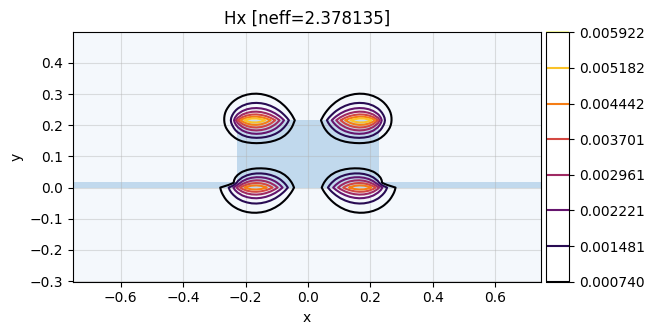

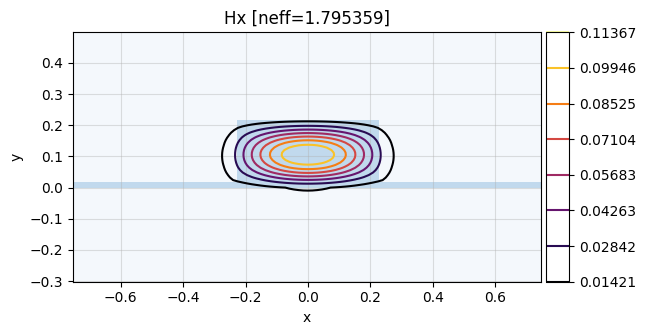

In [11]:
mw.visualize(modes[0][0], fields=["Hx"])
mw.visualize(modes[-1][1], fields=["Hx"])

## Calculate S-matrix (EME)

{'left@0': 0, 'left@1': 1, 'left@2': 2, 'left@3': 3, 'right@0': 4, 'right@1': 5, 'right@2': 6, 'right@3': 7}


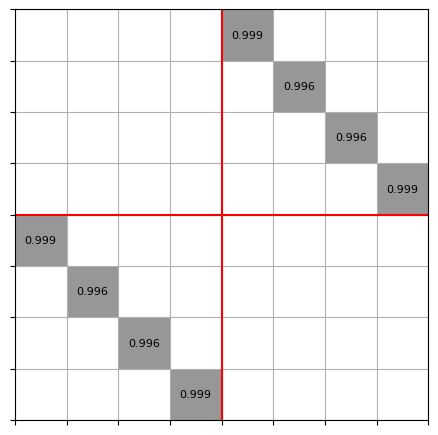

In [12]:
S, port_map = mw.compute_s_matrix(modes, cells)
print(port_map)
mw.visualize((abs(S), port_map))